In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_selection import RFE, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
df = pd.read_csv('NewCompsData5.csv', names=['Company','EV','TTM Revenue','Ev/Rev Multiple','Rev Growth','GP Margin','R&D Margin', 'S&M Margin', 'EBITDA Margin', 'Profit Margin'])
df[['EV','TTM Revenue','Ev/Rev Multiple','Rev Growth','GP Margin','R&D Margin', 'S&M Margin', 'EBITDA Margin', 'Profit Margin']] = df[['EV', 'TTM Revenue','Ev/Rev Multiple','Rev Growth','GP Margin','R&D Margin', 'S&M Margin', 'EBITDA Margin', 'Profit Margin']].apply(pd.to_numeric)

In [5]:
databricks = [1657.78663672243,66.65488, 0.951862931344295,0.671300585943595,0.577080777881529,0.981899434820076,0.261273981475219,-1.14895360823323,-1.11333236039661]
db = pd.DataFrame([databricks], columns = ['EV','TTM Revenue','Rev Growth','GP Margin','R&D Margin', 'S&M Margin', 'G&A Margin','EBITDA Margin', 'Profit Margin'])
db = db.drop(['G&A Margin'], axis=1)
db = db.as_matrix()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


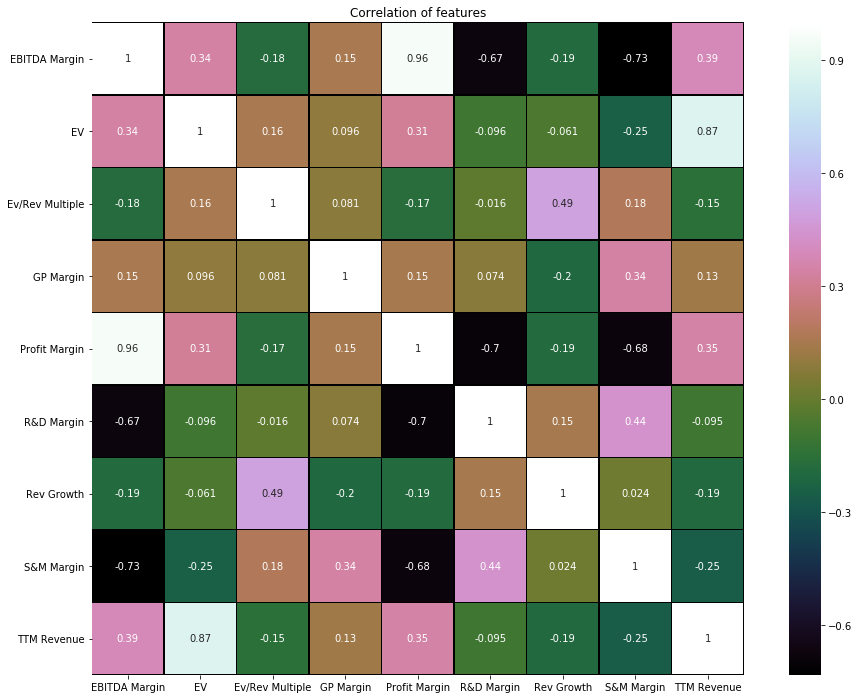

In [6]:
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in df.iteritems():
    if type(colvalue[1]) == str:
         str_list.append(colname)
# Get to the numeric columns by inversion            
num_list = df.columns.difference(str_list) 
# Create Dataframe containing only numerical features
df_num = df[num_list]
f, ax = plt.subplots(figsize=(16, 12))
plt.title('Correlation of features')
# Draw the heatmap using seaborn
#sns.heatmap(house_num.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="PuBuGn", linecolor='k', annot=True)
sns.heatmap(df_num.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="cubehelix", linecolor='k', annot=True)

In [7]:
# First extract the target variable which is our House prices
y = y = df[['Ev/Rev Multiple']]
y = y.values.ravel()
# Drop price from the house dataframe and create a matrix out of the house data
df = df.drop(['Ev/Rev Multiple', 'Company'], axis=1)
X = df.as_matrix()
# Store the column/feature names into a list "colnames"
colnames = df.columns

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [8]:
# Define dictionary to store our rankings
ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [9]:
# Finally let's run our Selection Stability method with Randomized Lasso
rlasso = RandomizedLasso(alpha=0.04)
rlasso.fit(X, Y)
ranks["rlasso/Stability"] = ranking(np.abs(rlasso.scores_), colnames)
print('finished')

NameError: name 'RandomizedLasso' is not defined

In [ ]:
# Construct our Linear Regression model
lr = LinearRegression(normalize=True)
lr.fit(X,Y)
#stop the search when only the last feature is left
rfe = RFE(lr, n_features_to_select=1, verbose =3 )
rfe.fit(X,Y)
ranks["RFE"] = ranking( list(map(float, rfe.ranking_)), colnames, order=-1)

In [ ]:
# Using Linear Regression
lr = LinearRegression(normalize=True)
lr.fit(X,Y)
ranks["LinReg"] = ranking(np.abs(lr.coef_), colnames)

# Using Ridge 
ridge = Ridge(alpha = 7)
ridge.fit(X,Y)
ranks['Ridge'] = ranking(np.abs(ridge.coef_), colnames)

# Using Lasso
lasso = Lasso(alpha=.05)
lasso.fit(X, Y)
ranks["Lasso"] = ranking(np.abs(lasso.coef_), colnames)

In [ ]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, verbose=3)
rf.fit(X,Y)
ranks["RF"] = ranking(rf.feature_importances_, colnames);

In [ ]:
r = {}
for name in colnames:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)
 
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
 
print("\t%s" % "\t".join(methods))
for name in colnames:
    print("%s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods]))))

In [ ]:
# Put the mean scores into a Pandas dataframe
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

# Sort the dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)

In [ ]:
# Let's plot the ranking of the features
sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", 
               size=14, aspect=1.9, palette='coolwarm');

In [ ]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import explained_variance_score, median_absolute_error, r2_score, mean_squared_error, accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model

from sklearn.grid_search import GridSearchCV

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split # Model evaluation
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler # Preprocessing
from sklearn.linear_model import Lasso, Ridge, ElasticNet, RANSACRegressor, SGDRegressor, HuberRegressor, BayesianRidge # Linear models
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor  # Ensemble methods
from xgboost import XGBRegressor, plot_importance # XGBoost
from sklearn.svm import SVR, SVC, LinearSVC  # Support Vector Regression
from sklearn.tree import DecisionTreeRegressor # Decision Tree Regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline # Streaming pipelines
from sklearn.decomposition import KernelPCA, PCA # Dimensionality reduction
from sklearn.feature_selection import SelectFromModel # Dimensionality reduction
from sklearn.model_selection import learning_curve, validation_curve, GridSearchCV # Model evaluation
from sklearn.base import clone # Clone estimator
from sklearn.metrics import mean_squared_error as MSE

In [14]:
# Drop price from the house dataframe and create a matrix out of the house data
df = df.drop(['TTM Revenue', 'EV', 'Profit Margin'], axis=1)
X = df.as_matrix()
# Store the column/feature names into a list "colnames"
colnames = df.columns

KeyError: "['TTM Revenue' 'EV' 'Profit Margin'] not found in axis"

In [17]:
df

,Rev Growth,GP Margin,R&D Margin,S&M Margin,EBITDA Margin
0,0.140213,0.852368,0.183214,0.379706,0.190930
1,0.033149,0.854870,0.154773,0.255786,0.347155
2,0.033458,0.895454,0.101420,0.228489,0.500626
3,0.324274,0.812349,0.438849,0.198422,0.045933
4,0.164258,0.880066,0.122168,0.064734,0.253076
5,0.288999,0.792802,0.207906,0.558176,-0.177660
6,0.170749,0.749036,0.129117,0.429765,0.131057
7,0.028465,0.847022,0.142969,0.345940,0.306661
8,0.071620,0.764383,0.300680,0.181713,0.215145
9,0.063581,0.882648,0.388533,0.202504,0.250359


In [16]:
qwe = LinearRegression()
q = qwe.fit(X_train, y_train)
q.score(X_test, y_test)

-0.2101842909093299

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=3)

In [65]:
thresh = 1 * 10**(-3)
model = XGBRegressor()
model.fit(X_train, y_train)
#select features using threshold
selection = SelectFromModel(model, threshold = thresh, prefit=True)
select_X_train = selection.transform(X_train)
# eval model
select_X_val = selection.transform(X_test)
# test 
select_X_test = selection.transform(X_test)

Scaled_Ridge: 0.206997 (+/- 0.467753)
Scaled_Lasso: 0.076909 (+/- 0.243097)
Scaled_Elastic: 0.096235 (+/- 0.208410)
Scaled_SVR: 0.251550 (+/- 0.411022)
Scaled_RF_reg: 0.195759 (+/- 0.492134)
Scaled_ET_reg: 0.127809 (+/- 0.434085)
Scaled_BR_reg: 0.223696 (+/- 0.434185)
Scaled_Hub-Reg: 0.224738 (+/- 0.444213)
Scaled_BayRidge: 0.210592 (+/- 0.438082)
Scaled_XGB_reg: 0.101270 (+/- 0.550627)
Scaled_DT_reg: -0.234030 (+/- 0.464933)
Scaled_KNN_reg: 0.079832 (+/- 0.386838)
Scaled_ADA-Reg: 0.253092 (+/- 0.362396)
Linear: 0.199892 (+/- 0.482351)
Scaled_Gboost-Reg: 0.057508 (+/- 0.618372)
Scaled_RFR_PCA: 0.292883 (+/- 0.329373)
Scaled_XGBR_PCA: 0.186726 (+/- 0.365501)


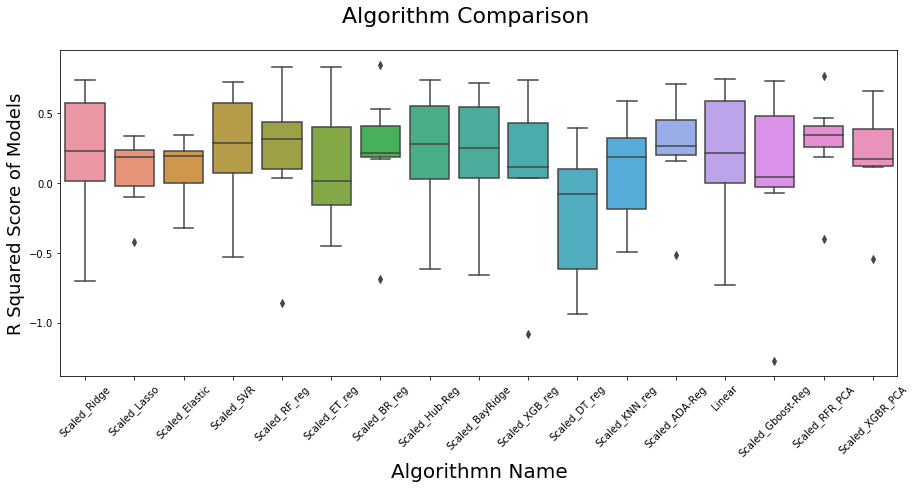

In [66]:
pipelines = []
seed = 2

pipelines.append(
                ("Scaled_Ridge", 
                 Pipeline([
                     ("Scaler", StandardScaler()), 
                     ("Ridge", Ridge(random_state=seed, tol=10 ))
                      ]))
                )
pipelines.append(
                ("Scaled_Lasso", 
                 Pipeline([
                     ("Scaler", StandardScaler()), 
                     ("Lasso", Lasso(random_state=seed, tol=1))
                      ]))
                )
pipelines.append(
                ("Scaled_Elastic", 
                 Pipeline([
                     ("Scaler", StandardScaler()), 
                     ("Lasso", ElasticNet(random_state=seed))
                      ]))
                )

pipelines.append(
                ("Scaled_SVR",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("SVR",  SVR(kernel='linear', C=1e2, degree=5))
                 ])
                )
                )

pipelines.append(
                ("Scaled_RF_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("RF", RandomForestRegressor(random_state=seed))
                 ])
                )
                )

pipelines.append(
                ("Scaled_ET_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("ET", ExtraTreesRegressor(random_state=seed))
                 ])
                )
                )
pipelines.append(
                ("Scaled_BR_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("BR", BaggingRegressor(random_state=seed))
                 ]))) 

pipelines.append(
                ("Scaled_Hub-Reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("Hub-Reg", HuberRegressor())
                 ]))) 
pipelines.append(
                ("Scaled_BayRidge",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("BR", BayesianRidge())
                 ]))) 

pipelines.append(
                ("Scaled_XGB_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("XGBR", XGBRegressor(seed=seed))
                 ]))) 

pipelines.append(
                ("Scaled_DT_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("DT_reg", DecisionTreeRegressor())
                 ]))) 

pipelines.append(
                ("Scaled_KNN_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("KNN_reg", KNeighborsRegressor())
                 ])))
pipelines.append(
                ("Scaled_ADA-Reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("ADA-reg", AdaBoostRegressor())
                 ]))) 

pipelines.append(
                ("Scaled_Linear",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("Linear", LinearRegression())
                 ]))) 

pipelines.append(
                ("Scaled_Gboost-Reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("GBoost-Reg", GradientBoostingRegressor())
                 ])))

pipelines.append(
                ("Scaled_RFR_PCA",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("PCA", PCA(n_components=3)),
                     ("XGB", RandomForestRegressor())
                 ])))

pipelines.append(
                ("Scaled_XGBR_PCA",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("PCA", PCA(n_components=3)),
                     ("XGB", XGBRegressor())
                 ])))

#'neg_mean_absolute_error', 'neg_mean_squared_error','r2'
scoring = 'r2'
n_folds = 7

results, names  = [], [] 

for name, model  in pipelines:
    kfold = KFold(n_splits=n_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv= kfold,
                                 scoring=scoring, n_jobs=-1)    
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,6))
fig.suptitle('Algorithm Comparison', fontsize=22)
ax = fig.add_subplot(111)
sns.boxplot(x=names, y=results)
ax.set_xticklabels(names)
ax.set_xlabel("Algorithmn Name", fontsize=20)
ax.set_ylabel("R Squared Score of Models", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [43]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [46]:
xgb.fit(select_X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.08, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [25]:
y_hat = xgb.predict(X_test)

In [47]:
xgb.score(select_X_test,y_test)

0.40340942135032615

In [48]:
xgb.predict(db)

array([14.577784], dtype=float32)

In [58]:
model = LinearRegression()
model = model.fit(X_train, y_train)
model.score(X_test,y_test)

0.5369859684626606

In [56]:
model = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
model = model.fit(X_train, y_train)
model.score(X_test,y_test)

0.40340942135032615

In [59]:
model.predict(db)

array([15.65971922])